In [2]:
import neuraluq as neuq
import neuraluq.variables as neuq_vars
from neuraluq.config import tf

import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [3]:
def load_data(noise_u, noise_f):
    data = sio.loadmat("../dataset/Burgy.mat")
    x_u_train, t_u_train = data["x_u_train"], data["t_u_train"]
    x_f_train, t_f_train = data["x_f_train"], data["t_f_train"]
    x_test, t_test, u_test = data["x_test"], data["t_test"], data["u_test"]
    x_test, t_test, u_test = (
        x_test.reshape([-1, 1]),
        t_test.reshape([-1, 1]),
        u_test.reshape([-1, 1]),
    )
    u_train, f_train = data["u_train"], data["f_train"]
    train_u = x_u_train, t_u_train, u_train
    train_f = x_f_train, t_f_train, f_train
    test = x_test, t_test, u_test
    return train_u, train_f, test

In [3]:
def pde_fn(x, u, nu):
    u_x, u_t = tf.split(tf.gradients(u, x)[0], 2, axis=-1)
    u_xx = tf.gradients(u_x, x)[0][..., 0:1]
    
    f = u_t + u * u_x - tf.exp(nu) * u_xx
    # f = u_t + u * u_x - nu * u_xx
    
    # tf.exp(k_1) Computes exponential of k_1 element-wise (y = e^{k_1})
    # (KDV) f = u_t - tf.exp(k_1) * u * u_x - tf.exp(k_2) * u_xxx 
    ### DA CAPIRE LA STORIA DEL PERCHè PRENDE L'ESPONENZIALE DELLE VARIABILI
    return f

In [4]:
@neuq.utils.timer
def Samplable(
    x_u_train, t_u_train, u_train, x_f_train, t_f_train, f_train, noise, layers
):
    # build processes
    process_u = neuq.process.Process(
        surrogate=neuq.surrogates.FNN(layers=layers),
        prior=neuq_vars.fnn.Samplable(layers=layers, mean=0, sigma=1),
    )
    process_logk_1 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Samplable(mean=0, sigma=1),
    )
    
    # build likelihood
    likelihood_u = neuq.likelihoods.Normal(
        inputs=np.concatenate([x_u_train, t_u_train], axis=-1),
        targets=u_train,
        processes=[process_u],
        sigma=noise,
    )
    likelihood_f = neuq.likelihoods.Normal(
        inputs=np.concatenate([x_f_train, t_f_train], axis=-1),
        targets=f_train,
        processes=[process_u, process_logk_1],
        pde=pde_fn,
        sigma=noise,
    )
    # build model
    model = neuq.models.Model(
        processes=[process_u, process_logk_1],
        likelihoods=[likelihood_u, likelihood_f],
    )
    # assign and compile method
    # Change the parameters to make the acceptance rate close to 0.6.
    method = neuq.inferences.HMC(
        num_samples=500,
        num_burnin=3000,
        init_time_step=0.01,
        leapfrog_step=50,
        seed=66,
    )
    model.compile(method)
    # obtain posterior samples
    samples, results = model.run()
    print("Acceptance rate: %.3f \n"%(np.mean(results)))

    processes = [process_u, process_logk_1]
    return processes, samples, model


In [5]:
@neuq.utils.timer
def Trainable(
    x_u_train, t_u_train, u_train, x_f_train, t_f_train, f_train, noise, layers
):
    # build processes
    process_u = neuq.process.Process(
        surrogate=neuq.surrogates.FNN(layers=layers),
        posterior=neuq_vars.fnn.Trainable(layers=layers),
    )
    process_logk_1 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        posterior=neuq_vars.const.Trainable(value=0),
    )
    
    loss_u = neuq.likelihoods.MSE(
        inputs=np.concatenate([x_u_train, t_u_train], axis=-1),
        targets=u_train,
        processes=[process_u],
        multiplier=1.0,
    )
    loss_f = neuq.likelihoods.MSE(
        inputs=np.concatenate([x_f_train, t_f_train], axis=-1),
        targets=f_train,
        processes=[process_u, process_logk_1],
        pde=pde_fn,
        multiplier=1.0,
    )
    # build model
    model = neuq.models.Model(
        processes=[process_u, process_logk_1],
        likelihoods=[loss_u, loss_f],
    )
    # assign and compile method
    method = neuq.inferences.DEns(
        num_samples=20, num_iterations=20000, optimizer=tf.train.AdamOptimizer(1e-3),
    )
    model.compile(method)
    # obtain posterior samples
    samples = model.run()
    samples = neuq.utils.batch_samples(samples)  # reshape

    processes = [process_u, process_logk_1]
    return processes, samples, model

In [6]:
NT, NX = 60, 300
noise = 0.1
train_u, train_f, test = load_data(noise, noise)
x_u_train, t_u_train, u_train = train_u
x_f_train, t_f_train, f_train = train_f
x_test, t_test, u_test = test

layers = [2, 50, 50, 1]

In [7]:
#processes, samples, model = Samplable(x_u_train, t_u_train, u_train, x_f_train, t_f_train, f_train, noise, layers,)

processes, samples, model = Trainable(x_u_train, t_u_train, u_train, x_f_train, t_f_train, f_train, noise, layers,)

Supporting backend tensorflow.compat.v1

Compiling a Ensemble method

Generating 0th sample by deep ensemble...
Iteration:  0 , loss:  0.3652232
Iteration:  100 , loss:  0.0703895
Iteration:  200 , loss:  0.06843974
Iteration:  300 , loss:  0.06757279
Iteration:  400 , loss:  0.066427395
Iteration:  500 , loss:  0.06444074
Iteration:  600 , loss:  0.062028404
Iteration:  700 , loss:  0.058660846
Iteration:  800 , loss:  0.053187974
Iteration:  900 , loss:  0.040957056
Iteration:  1000 , loss:  0.026896399
Iteration:  1100 , loss:  0.01705359
Iteration:  1200 , loss:  0.0135277435
Iteration:  1300 , loss:  0.011614578
Iteration:  1400 , loss:  0.010199091
Iteration:  1500 , loss:  0.009205456
Iteration:  1600 , loss:  0.008418981
Iteration:  1700 , loss:  0.007609942
Iteration:  1800 , loss:  0.006856897
Iteration:  1900 , loss:  0.0062328717
Iteration:  2000 , loss:  0.005742346
Iteration:  2100 , loss:  0.00546147
Iteration:  2200 , loss:  0.0048821256
Iteration:  2300 , loss:  0.0045

Iteration:  500 , loss:  0.053985294
Iteration:  600 , loss:  0.040922944
Iteration:  700 , loss:  0.03175706
Iteration:  800 , loss:  0.02157424
Iteration:  900 , loss:  0.014277218
Iteration:  1000 , loss:  0.011948502
Iteration:  1100 , loss:  0.010796243
Iteration:  1200 , loss:  0.00973323
Iteration:  1300 , loss:  0.00880808
Iteration:  1400 , loss:  0.008329008
Iteration:  1500 , loss:  0.007647071
Iteration:  1600 , loss:  0.007196172
Iteration:  1700 , loss:  0.0068134237
Iteration:  1800 , loss:  0.00641252
Iteration:  1900 , loss:  0.0060056746
Iteration:  2000 , loss:  0.0056338394
Iteration:  2100 , loss:  0.0061041247
Iteration:  2200 , loss:  0.005053987
Iteration:  2300 , loss:  0.0063541858
Iteration:  2400 , loss:  0.004529227
Iteration:  2500 , loss:  0.004818014
Iteration:  2600 , loss:  0.0040301224
Iteration:  2700 , loss:  0.0037880728
Iteration:  2800 , loss:  0.0035711112
Iteration:  2900 , loss:  0.0033982124
Iteration:  3000 , loss:  0.0031958907
Iteration:  

Iteration:  1500 , loss:  0.015449617
Iteration:  1600 , loss:  0.014562054
Iteration:  1700 , loss:  0.013735628
Iteration:  1800 , loss:  0.012885008
Iteration:  1900 , loss:  0.012195576
Iteration:  2000 , loss:  0.010898817
Iteration:  2100 , loss:  0.009872209
Iteration:  2200 , loss:  0.0090470845
Iteration:  2300 , loss:  0.00839694
Iteration:  2400 , loss:  0.008059665
Iteration:  2500 , loss:  0.0070332703
Iteration:  2600 , loss:  0.0064500733
Iteration:  2700 , loss:  0.005885733
Iteration:  2800 , loss:  0.0054691937
Iteration:  2900 , loss:  0.0051498148
Iteration:  3000 , loss:  0.0048610186
Iteration:  3100 , loss:  0.0046280194
Iteration:  3200 , loss:  0.0045159985
Iteration:  3300 , loss:  0.00421473
Iteration:  3400 , loss:  0.004017575
Iteration:  3500 , loss:  0.0038085447
Iteration:  3600 , loss:  0.0035965643
Iteration:  3700 , loss:  0.0033934286
Iteration:  3800 , loss:  0.0031975375
Iteration:  3900 , loss:  0.0030197357
Iteration:  4000 , loss:  0.0030984716


Iteration:  2200 , loss:  0.0058752703
Iteration:  2300 , loss:  0.005333258
Iteration:  2400 , loss:  0.004937574
Iteration:  2500 , loss:  0.0045850584
Iteration:  2600 , loss:  0.005063431
Iteration:  2700 , loss:  0.004004759
Iteration:  2800 , loss:  0.0037650885
Iteration:  2900 , loss:  0.0035712298
Iteration:  3000 , loss:  0.0033980994
Iteration:  3100 , loss:  0.0032522716
Iteration:  3200 , loss:  0.003117106
Iteration:  3300 , loss:  0.0030396665
Iteration:  3400 , loss:  0.0028969017
Iteration:  3500 , loss:  0.0028545652
Iteration:  3600 , loss:  0.0027074865
Iteration:  3700 , loss:  0.0026918568
Iteration:  3800 , loss:  0.0025303308
Iteration:  3900 , loss:  0.0026282803
Iteration:  4000 , loss:  0.0023646238
Iteration:  4100 , loss:  0.002293271
Iteration:  4200 , loss:  0.002202887
Iteration:  4300 , loss:  0.0021248944
Iteration:  4400 , loss:  0.002052656
Iteration:  4500 , loss:  0.0019753014
Iteration:  4600 , loss:  0.0019099051
Iteration:  4700 , loss:  0.00203

Iteration:  3000 , loss:  0.003228443
Iteration:  3100 , loss:  0.0030740108
Iteration:  3200 , loss:  0.0029057667
Iteration:  3300 , loss:  0.0030353651
Iteration:  3400 , loss:  0.0026111063
Iteration:  3500 , loss:  0.002481875
Iteration:  3600 , loss:  0.0023522724
Iteration:  3700 , loss:  0.002255708
Iteration:  3800 , loss:  0.0021069525
Iteration:  3900 , loss:  0.0019884785
Iteration:  4000 , loss:  0.0019064418
Iteration:  4100 , loss:  0.0017613405
Iteration:  4200 , loss:  0.0016530133
Iteration:  4300 , loss:  0.001557085
Iteration:  4400 , loss:  0.0014695639
Iteration:  4500 , loss:  0.0013929902
Iteration:  4600 , loss:  0.0013229644
Iteration:  4700 , loss:  0.001263971
Iteration:  4800 , loss:  0.0013309887
Iteration:  4900 , loss:  0.0011614531
Iteration:  5000 , loss:  0.0012096091
Iteration:  5100 , loss:  0.0010773872
Iteration:  5200 , loss:  0.0015888576
Iteration:  5300 , loss:  0.0010044277
Iteration:  5400 , loss:  0.0010315294
Iteration:  5500 , loss:  0.00

Iteration:  3700 , loss:  0.0016695496
Iteration:  3800 , loss:  0.0016268436
Iteration:  3900 , loss:  0.0015661058
Iteration:  4000 , loss:  0.0015213906
Iteration:  4100 , loss:  0.0014750548
Iteration:  4200 , loss:  0.0014343581
Iteration:  4300 , loss:  0.0013908516
Iteration:  4400 , loss:  0.0013667457
Iteration:  4500 , loss:  0.0013134584
Iteration:  4600 , loss:  0.0016358993
Iteration:  4700 , loss:  0.0012402928
Iteration:  4800 , loss:  0.0012036875
Iteration:  4900 , loss:  0.0011698507
Iteration:  5000 , loss:  0.0013441648
Iteration:  5100 , loss:  0.0011041523
Iteration:  5200 , loss:  0.0010738717
Iteration:  5300 , loss:  0.0014335823
Iteration:  5400 , loss:  0.0010962316
Iteration:  5500 , loss:  0.0010007427
Iteration:  5600 , loss:  0.00096639455
Iteration:  5700 , loss:  0.00094595586
Iteration:  5800 , loss:  0.0013563689
Iteration:  5900 , loss:  0.00092751265
Iteration:  6000 , loss:  0.0009570598
Iteration:  6100 , loss:  0.000860411
Iteration:  6200 , loss

Iteration:  4500 , loss:  0.0012610039
Iteration:  4600 , loss:  0.0011927814
Iteration:  4700 , loss:  0.001137136
Iteration:  4800 , loss:  0.0010901337
Iteration:  4900 , loss:  0.0018079829
Iteration:  5000 , loss:  0.001014933
Iteration:  5100 , loss:  0.0009861452
Iteration:  5200 , loss:  0.0009641998
Iteration:  5300 , loss:  0.00093838765
Iteration:  5400 , loss:  0.0009814352
Iteration:  5500 , loss:  0.0009131691
Iteration:  5600 , loss:  0.0008931632
Iteration:  5700 , loss:  0.000868394
Iteration:  5800 , loss:  0.0009339538
Iteration:  5900 , loss:  0.00086529314
Iteration:  6000 , loss:  0.0008648317
Iteration:  6100 , loss:  0.00082175946
Iteration:  6200 , loss:  0.00081023143
Iteration:  6300 , loss:  0.0008028937
Iteration:  6400 , loss:  0.00080370286
Iteration:  6500 , loss:  0.0013360947
Iteration:  6600 , loss:  0.0008129366
Iteration:  6700 , loss:  0.0007709937
Iteration:  6800 , loss:  0.0015773361
Iteration:  6900 , loss:  0.0007607768
Iteration:  7000 , loss

Iteration:  5200 , loss:  0.001411151
Iteration:  5300 , loss:  0.0012852481
Iteration:  5400 , loss:  0.0012685794
Iteration:  5500 , loss:  0.0013368421
Iteration:  5600 , loss:  0.0012003644
Iteration:  5700 , loss:  0.0015620757
Iteration:  5800 , loss:  0.0021984326
Iteration:  5900 , loss:  0.001070927
Iteration:  6000 , loss:  0.001125173
Iteration:  6100 , loss:  0.0010278639
Iteration:  6200 , loss:  0.001006806
Iteration:  6300 , loss:  0.000989151
Iteration:  6400 , loss:  0.0010163211
Iteration:  6500 , loss:  0.00095138134
Iteration:  6600 , loss:  0.0009367002
Iteration:  6700 , loss:  0.00091956137
Iteration:  6800 , loss:  0.0009052581
Iteration:  6900 , loss:  0.0009905433
Iteration:  7000 , loss:  0.0008787133
Iteration:  7100 , loss:  0.0011772773
Iteration:  7200 , loss:  0.0008558451
Iteration:  7300 , loss:  0.0009805755
Iteration:  7400 , loss:  0.00083593273
Iteration:  7500 , loss:  0.0009742397
Iteration:  7600 , loss:  0.0008191344
Iteration:  7700 , loss:  0

Iteration:  6000 , loss:  0.0005320188
Iteration:  6100 , loss:  0.0005672727
Iteration:  6200 , loss:  0.0006833515
Iteration:  6300 , loss:  0.0005120554
Iteration:  6400 , loss:  0.0005128777
Iteration:  6500 , loss:  0.000507114
Iteration:  6600 , loss:  0.00050498615
Iteration:  6700 , loss:  0.0005029519
Iteration:  6800 , loss:  0.00050308934
Iteration:  6900 , loss:  0.00068954873
Iteration:  7000 , loss:  0.0005374393
Iteration:  7100 , loss:  0.000494766
Iteration:  7200 , loss:  0.0005931484
Iteration:  7300 , loss:  0.00052238593
Iteration:  7400 , loss:  0.0005192142
Iteration:  7500 , loss:  0.00049076497
Iteration:  7600 , loss:  0.00048907154
Iteration:  7700 , loss:  0.00048659704
Iteration:  7800 , loss:  0.0004870833
Iteration:  7900 , loss:  0.0005160755
Iteration:  8000 , loss:  0.00048252754
Iteration:  8100 , loss:  0.00053901423
Iteration:  8200 , loss:  0.00058349094
Iteration:  8300 , loss:  0.00047977714
Iteration:  8400 , loss:  0.00047819383
Iteration:  850

Iteration:  6600 , loss:  0.0012293649
Iteration:  6700 , loss:  0.0012250908
Iteration:  6800 , loss:  0.0012004289
Iteration:  6900 , loss:  0.0011877421
Iteration:  7000 , loss:  0.0024328337
Iteration:  7100 , loss:  0.0011606875
Iteration:  7200 , loss:  0.0011479564
Iteration:  7300 , loss:  0.0011344354
Iteration:  7400 , loss:  0.0011261352
Iteration:  7500 , loss:  0.0011311874
Iteration:  7600 , loss:  0.001095884
Iteration:  7700 , loss:  0.0010880781
Iteration:  7800 , loss:  0.0010705731
Iteration:  7900 , loss:  0.0011271511
Iteration:  8000 , loss:  0.0010448401
Iteration:  8100 , loss:  0.0010327627
Iteration:  8200 , loss:  0.0010238882
Iteration:  8300 , loss:  0.0010076826
Iteration:  8400 , loss:  0.0009960128
Iteration:  8500 , loss:  0.0010380823
Iteration:  8600 , loss:  0.0009715799
Iteration:  8700 , loss:  0.0009750306
Iteration:  8800 , loss:  0.0010062456
Iteration:  8900 , loss:  0.0009365246
Iteration:  9000 , loss:  0.0009241712
Iteration:  9100 , loss:  

Iteration:  7200 , loss:  0.0005080315
Iteration:  7300 , loss:  0.00053623016
Iteration:  7400 , loss:  0.0005002156
Iteration:  7500 , loss:  0.0004925947
Iteration:  7600 , loss:  0.00049212243
Iteration:  7700 , loss:  0.00048685283
Iteration:  7800 , loss:  0.00048585
Iteration:  7900 , loss:  0.00048382822
Iteration:  8000 , loss:  0.00048036792
Iteration:  8100 , loss:  0.00047790352
Iteration:  8200 , loss:  0.0004747334
Iteration:  8300 , loss:  0.0012178224
Iteration:  8400 , loss:  0.00047012666
Iteration:  8500 , loss:  0.0004898208
Iteration:  8600 , loss:  0.0004737995
Iteration:  8700 , loss:  0.00046829326
Iteration:  8800 , loss:  0.00046217407
Iteration:  8900 , loss:  0.00046092836
Iteration:  9000 , loss:  0.0004918047
Iteration:  9100 , loss:  0.00045656844
Iteration:  9200 , loss:  0.00045528688
Iteration:  9300 , loss:  0.0004794118
Iteration:  9400 , loss:  0.0005646164
Iteration:  9500 , loss:  0.00044976873
Iteration:  9600 , loss:  0.0004481424
Iteration:  97

Iteration:  8000 , loss:  0.00072543626
Iteration:  8100 , loss:  0.000712269
Iteration:  8200 , loss:  0.0007051648
Iteration:  8300 , loss:  0.00072309293
Iteration:  8400 , loss:  0.0006938304
Iteration:  8500 , loss:  0.0006888519
Iteration:  8600 , loss:  0.00068829645
Iteration:  8700 , loss:  0.0006822746
Iteration:  8800 , loss:  0.0014733206
Iteration:  8900 , loss:  0.0006678734
Iteration:  9000 , loss:  0.00066388736
Iteration:  9100 , loss:  0.00066027656
Iteration:  9200 , loss:  0.00065403205
Iteration:  9300 , loss:  0.00064853573
Iteration:  9400 , loss:  0.0006556352
Iteration:  9500 , loss:  0.0007331933
Iteration:  9600 , loss:  0.0006407225
Iteration:  9700 , loss:  0.0006473837
Iteration:  9800 , loss:  0.0006554616
Iteration:  9900 , loss:  0.0006296673
Iteration:  10000 , loss:  0.0006201231
Iteration:  10100 , loss:  0.0006970145
Iteration:  10200 , loss:  0.00096056034
Iteration:  10300 , loss:  0.00060532155
Iteration:  10400 , loss:  0.0006047443
Iteration:  

Iteration:  8600 , loss:  0.00076914125
Iteration:  8700 , loss:  0.00062930293
Iteration:  8800 , loss:  0.0007534261
Iteration:  8900 , loss:  0.0006151907
Iteration:  9000 , loss:  0.00061163644
Iteration:  9100 , loss:  0.00060800987
Iteration:  9200 , loss:  0.00060114235
Iteration:  9300 , loss:  0.0010834556
Iteration:  9400 , loss:  0.0005915785
Iteration:  9500 , loss:  0.00058862276
Iteration:  9600 , loss:  0.0005876062
Iteration:  9700 , loss:  0.0006000553
Iteration:  9800 , loss:  0.00057749264
Iteration:  9900 , loss:  0.00058824464
Iteration:  10000 , loss:  0.00057117257
Iteration:  10100 , loss:  0.0005682519
Iteration:  10200 , loss:  0.0005662997
Iteration:  10300 , loss:  0.00056351733
Iteration:  10400 , loss:  0.00058606634
Iteration:  10500 , loss:  0.0006748437
Iteration:  10600 , loss:  0.0005670647
Iteration:  10700 , loss:  0.00064818026
Iteration:  10800 , loss:  0.00057710614
Iteration:  10900 , loss:  0.0006706548
Iteration:  11000 , loss:  0.0005564501
I

Iteration:  9400 , loss:  0.0005281008
Iteration:  9500 , loss:  0.00075779256
Iteration:  9600 , loss:  0.00080550445
Iteration:  9700 , loss:  0.00054649555
Iteration:  9800 , loss:  0.00051761226
Iteration:  9900 , loss:  0.0005112152
Iteration:  10000 , loss:  0.0005203411
Iteration:  10100 , loss:  0.00050467363
Iteration:  10200 , loss:  0.0004996185
Iteration:  10300 , loss:  0.0004970344
Iteration:  10400 , loss:  0.0011877695
Iteration:  10500 , loss:  0.0004911135
Iteration:  10600 , loss:  0.00051686715
Iteration:  10700 , loss:  0.00070191466
Iteration:  10800 , loss:  0.00048544124
Iteration:  10900 , loss:  0.0005929739
Iteration:  11000 , loss:  0.00057651085
Iteration:  11100 , loss:  0.00047753635
Iteration:  11200 , loss:  0.00047570237
Iteration:  11300 , loss:  0.00047305773
Iteration:  11400 , loss:  0.0005494131
Iteration:  11500 , loss:  0.0005243778
Iteration:  11600 , loss:  0.0005196201
Iteration:  11700 , loss:  0.0004703665
Iteration:  11800 , loss:  0.00046

Iteration:  10000 , loss:  0.0005368181
Iteration:  10100 , loss:  0.0006980843
Iteration:  10200 , loss:  0.0005331875
Iteration:  10300 , loss:  0.0006421084
Iteration:  10400 , loss:  0.0005301089
Iteration:  10500 , loss:  0.00074745587
Iteration:  10600 , loss:  0.0005273108
Iteration:  10700 , loss:  0.00058032654
Iteration:  10800 , loss:  0.00054151285
Iteration:  10900 , loss:  0.0005250619
Iteration:  11000 , loss:  0.00059520407
Iteration:  11100 , loss:  0.00052980386
Iteration:  11200 , loss:  0.00054957584
Iteration:  11300 , loss:  0.00059339724
Iteration:  11400 , loss:  0.0005285787
Iteration:  11500 , loss:  0.00051623856
Iteration:  11600 , loss:  0.00051991176
Iteration:  11700 , loss:  0.0005476454
Iteration:  11800 , loss:  0.00081874407
Iteration:  11900 , loss:  0.00051364297
Iteration:  12000 , loss:  0.00054789847
Iteration:  12100 , loss:  0.00056961237
Iteration:  12200 , loss:  0.00051287154
Iteration:  12300 , loss:  0.00050938514
Iteration:  12400 , loss:

Iteration:  10800 , loss:  0.00067723304
Iteration:  10900 , loss:  0.00068082585
Iteration:  11000 , loss:  0.0007900636
Iteration:  11100 , loss:  0.0006612889
Iteration:  11200 , loss:  0.0006591846
Iteration:  11300 , loss:  0.00066566386
Iteration:  11400 , loss:  0.00065301824
Iteration:  11500 , loss:  0.00064553856
Iteration:  11600 , loss:  0.0024883666
Iteration:  11700 , loss:  0.0006346958
Iteration:  11800 , loss:  0.0006308936
Iteration:  11900 , loss:  0.00062923844
Iteration:  12000 , loss:  0.0006306488
Iteration:  12100 , loss:  0.0006198666
Iteration:  12200 , loss:  0.0006197939
Iteration:  12300 , loss:  0.0007580547
Iteration:  12400 , loss:  0.0006103376
Iteration:  12500 , loss:  0.00060716295
Iteration:  12600 , loss:  0.00060464145
Iteration:  12700 , loss:  0.0006030487
Iteration:  12800 , loss:  0.00062358053
Iteration:  12900 , loss:  0.0005959288
Iteration:  13000 , loss:  0.000768055
Iteration:  13100 , loss:  0.00059419475
Iteration:  13200 , loss:  0.00

Iteration:  11600 , loss:  0.0013826811
Iteration:  11700 , loss:  0.00049610157
Iteration:  11800 , loss:  0.0004960144
Iteration:  11900 , loss:  0.00049002457
Iteration:  12000 , loss:  0.0004927646
Iteration:  12100 , loss:  0.00056348304
Iteration:  12200 , loss:  0.0004933474
Iteration:  12300 , loss:  0.00049081026
Iteration:  12400 , loss:  0.0006521289
Iteration:  12500 , loss:  0.00055943994
Iteration:  12600 , loss:  0.00049685675
Iteration:  12700 , loss:  0.00052472693
Iteration:  12800 , loss:  0.0005023792
Iteration:  12900 , loss:  0.0006237544
Iteration:  13000 , loss:  0.0004804409
Iteration:  13100 , loss:  0.0013143866
Iteration:  13200 , loss:  0.0004710936
Iteration:  13300 , loss:  0.00062668725
Iteration:  13400 , loss:  0.001256987
Iteration:  13500 , loss:  0.00046742448
Iteration:  13600 , loss:  0.00055531727
Iteration:  13700 , loss:  0.00046482458
Iteration:  13800 , loss:  0.0004986534
Iteration:  13900 , loss:  0.00060513266
Iteration:  14000 , loss:  0.

Iteration:  12300 , loss:  0.00081707863
Iteration:  12400 , loss:  0.000632164
Iteration:  12500 , loss:  0.0013705676
Iteration:  12600 , loss:  0.0006230189
Iteration:  12700 , loss:  0.00061828183
Iteration:  12800 , loss:  0.00062955864
Iteration:  12900 , loss:  0.0006100529
Iteration:  13000 , loss:  0.0006071951
Iteration:  13100 , loss:  0.0006027679
Iteration:  13200 , loss:  0.000629275
Iteration:  13300 , loss:  0.00064566
Iteration:  13400 , loss:  0.000592463
Iteration:  13500 , loss:  0.000588988
Iteration:  13600 , loss:  0.0005894253
Iteration:  13700 , loss:  0.00058298896
Iteration:  13800 , loss:  0.00058062794
Iteration:  13900 , loss:  0.00059555174
Iteration:  14000 , loss:  0.0006056282
Iteration:  14100 , loss:  0.00057234307
Iteration:  14200 , loss:  0.0019387295
Iteration:  14300 , loss:  0.0005676993
Iteration:  14400 , loss:  0.00058983825
Iteration:  14500 , loss:  0.0007928086
Iteration:  14600 , loss:  0.00056080666
Iteration:  14700 , loss:  0.00060732

Iteration:  13000 , loss:  0.0009038113
Iteration:  13100 , loss:  0.0006041885
Iteration:  13200 , loss:  0.00047648506
Iteration:  13300 , loss:  0.00047328818
Iteration:  13400 , loss:  0.00048053812
Iteration:  13500 , loss:  0.000489983
Iteration:  13600 , loss:  0.00046706598
Iteration:  13700 , loss:  0.0005413597
Iteration:  13800 , loss:  0.0004899369
Iteration:  13900 , loss:  0.00046157808
Iteration:  14000 , loss:  0.00046066806
Iteration:  14100 , loss:  0.0015597122
Iteration:  14200 , loss:  0.00045662944
Iteration:  14300 , loss:  0.00045810288
Iteration:  14400 , loss:  0.00045422366
Iteration:  14500 , loss:  0.00050585996
Iteration:  14600 , loss:  0.00045080233
Iteration:  14700 , loss:  0.00047959195
Iteration:  14800 , loss:  0.00044814806
Iteration:  14900 , loss:  0.00061371154
Iteration:  15000 , loss:  0.0004455491
Iteration:  15100 , loss:  0.0006640607
Iteration:  15200 , loss:  0.00047315756
Iteration:  15300 , loss:  0.0004418954
Iteration:  15400 , loss: 

Iteration:  13800 , loss:  0.0004563643
Iteration:  13900 , loss:  0.0004532203
Iteration:  14000 , loss:  0.00045150478
Iteration:  14100 , loss:  0.0004583581
Iteration:  14200 , loss:  0.00045053387
Iteration:  14300 , loss:  0.00044758408
Iteration:  14400 , loss:  0.00046801634
Iteration:  14500 , loss:  0.00044514344
Iteration:  14600 , loss:  0.00044558616
Iteration:  14700 , loss:  0.00044311892
Iteration:  14800 , loss:  0.0004427375
Iteration:  14900 , loss:  0.00044103968
Iteration:  15000 , loss:  0.000463613
Iteration:  15100 , loss:  0.00043880672
Iteration:  15200 , loss:  0.00043803646
Iteration:  15300 , loss:  0.00045292094
Iteration:  15400 , loss:  0.0004753957
Iteration:  15500 , loss:  0.00043503454
Iteration:  15600 , loss:  0.00043483288
Iteration:  15700 , loss:  0.00043325598
Iteration:  15800 , loss:  0.00043248216
Iteration:  15900 , loss:  0.00043160372
Iteration:  16000 , loss:  0.0004353169
Iteration:  16100 , loss:  0.00057939393
Iteration:  16200 , loss

In [8]:
def plots(
    logk_1_pred,
    u_pred,
    x_test,
    t_test,
    u_test,
    x_u_train,
    t_u_train,
    u_train,
):
    ### DA CAPIRE LA STORIA DEL PERCHè PRENDE L'ESPONENZIALE DELLE VARIABILI
    
    k_1_pred = np.exp(logk_1_pred)
    #k_1_pred = logk_1_pred
    print("Mean & Std of k1 are %.3f, %.3f" % (np.mean(k_1_pred), np.std(k_1_pred)))
    
    u_pred = np.reshape(u_pred, [-1, NT, NX])
    mu = np.mean(u_pred, axis=0)
    std = np.std(u_pred, axis=0)
    
    x_test = np.reshape(x_test, [NT, NX])
    t_test = np.reshape(t_test, [NT, NX])
    u_test = np.reshape(u_test, [NT, NX])
    
    # cambiare i per avere plot su altri istanti di tempo
    i = 0
    
    current_t = t_test[i][0]
    # current_x*10 PERCHè PRIMA LA X è STATA NORMALIZZATA
    current_x = x_u_train[t_u_train == current_t]*10
    current_u = u_train[t_u_train == current_t]
    # std = np.sqrt(std**2 + 0.1**2)
    plt.plot(np.linspace(-10, 10, 300), mu[i, :], "--", label="mean")
    plt.fill_between(
        np.linspace(-10, 10, 300), (mu + 2 * std)[i, :], (mu - 2 * std)[i, :], alpha=0.3
    )
    plt.plot(np.linspace(-10, 10, 300), u_test[i, :], label="reference")
    plt.plot(current_x, current_u, "o", label="observations")
    plt.legend()
    plt.title("t=" + str(current_t))
    plt.show()

In [9]:
u_pred, logk_1_pred = model.predict(np.concatenate([x_test, t_test], axis=-1), samples, processes, pde_fn=None,)

Mean & Std of k1 are 0.502, 0.007


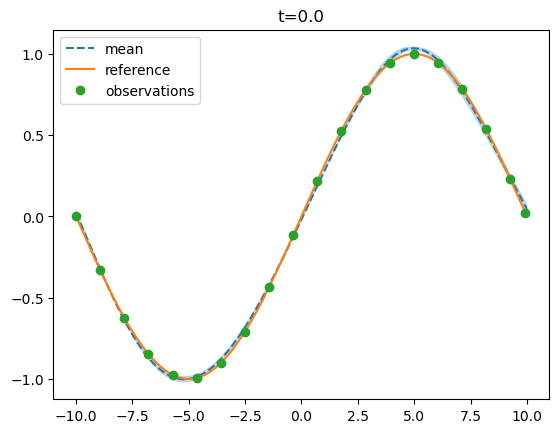

In [10]:
plots(
    logk_1_pred,
    u_pred,
    x_test,
    t_test,
    u_test,
    x_u_train,
    t_u_train,
    u_train,
)

# MEAN DELLA VARIABILE DIPENDE MOLTO DAL TRAINING SET

In [5]:
"""NeuralUQ for 1-D Poisson equation (forward), from B-PINN paper."""


# See also this paper for reference: 
# B-PINNs: Bayesian physics-informed neural networks for forward and inverse PDE problems with noisy data

import neuraluq as neuq
from neuraluq.config import tf

import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

def pde_fn(x, u):
    #nu = np.mean(k_1_pred)
    nu = 0.5
    u_x, u_t = tf.split(tf.gradients(u, x)[0], 2, axis=-1)
    #u_x = tf.gradients(u, x)[0]
    u_xx = tf.gradients(u_x, x)[0][..., 0:1]
    
    f = u_t + u * u_x - tf.exp(nu) * u_xx
    #f = u * u_x - tf.exp(nu) * u_xx
    # f = u_t + u * u_x - nu * u_xx
    
    # tf.exp(k_1) Computes exponential of k_1 element-wise (y = e^{k_1})
    # (KDV) f = u_t - tf.exp(k_1) * u * u_x - tf.exp(k_2) * u_xxx 
    ### DA CAPIRE LA STORIA DEL PERCHè PRENDE L'ESPONENZIALE DELLE VARIABILI
    return f


################## Load data and specify some hyperparameters ####################
NT, NX = 60, 300
noise = 0.1
train_u, train_f, test = load_data(noise, noise)
x_u_train, t_u_train, u_train = train_u
x_f_train, t_f_train, f_train = train_f
x_test, t_test, u_test = test
'''
x = np.linspace(0, 399, 20)
xx = [int(arr) for arr in x]

t_u_train = tt_u_train[:20]

x_u_train = xx_u_train[xx]

#for i in range(20):
i = 0
u_train = uu_train[(20*i):(20*(i+1))]
f_train = ff_train[(5*i):(5*(i+1))]
'''
layers = [2, 50, 50, 1]

####################### Build model and perform inference ########################
# All models share the same general procedure:
# Step 1: build surrogate, e.g. a fully-connected neural network, using [surrogates]
# Step 2: build prior and/or posterior using [variables]
# Step 3: build process, based the surrogate, prior and/or posterior, using [Process]
# Step 4: build likelihood, given noisy measurements, using [likelihoods]
# Step 5: build model using [models]
# Step 6: create an inference method and assign it to the model using [inferences]
# Step 7: perform posterior sampling using [model.run]

process = neuq.process.Process(
    surrogate=neuq.surrogates.FNN(layers=layers),
    prior=neuq.variables.fnn.Samplable(layers=layers, mean=0, sigma=1),
)

likelihood_u = neuq.likelihoods.Normal(
    inputs=np.concatenate([x_u_train, t_u_train], axis=-1),
    targets=u_train,
    processes=[process],
    pde=None,
    sigma=noise,
)
likelihood_f = neuq.likelihoods.Normal(
    inputs=np.concatenate([x_f_train, t_f_train], axis=-1),
    targets=x_f_train,
    processes=[process],
    pde=pde_fn,
    sigma=noise,
)

model = neuq.models.Model(
    processes=[process],
    likelihoods=[likelihood_u, likelihood_f],
)
method = neuq.inferences.HMC(
        num_samples=500,
        num_burnin=3000,
        init_time_step=0.01,
        leapfrog_step=50,
        seed=66,
    )
model.compile(method)
samples, results = model.run()
print("Acceptance rate: %.3f \n"%(np.mean(results)))  # if HMC is used

################################# Predictions ####################################
(u_pred,) = model.predict(np.concatenate([x_test, t_test], axis=-1), samples, processes=[process], pde_fn=None,)
(f_pred,) = model.predict(np.concatenate([x_test, t_test], axis=-1), samples, processes=[process], pde_fn=pde_fn,)


Supporting backend tensorflow.compat.v1

Compiling a MCMC method

sampling from posterior distribution ...

Finished sampling from posterior distribution ...

Acceptance rate: 0.384 



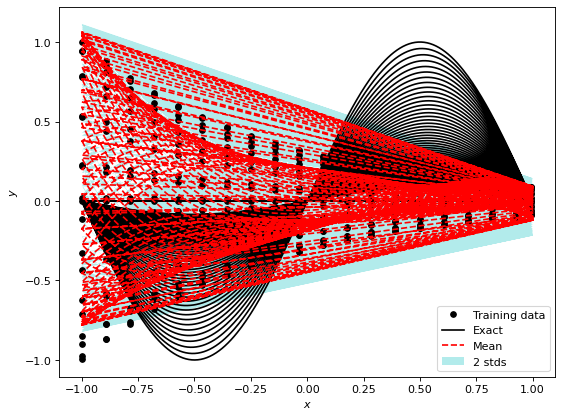

NameError: name 'f_test' is not defined

In [6]:
############################### Postprocessing ###################################
neuq.utils.plot1d(x_u_train, u_train, x_test, u_test, u_pred[..., 0])

#neuq.utils.plot1d(x_f_train, f_train, x_test, f_test, f_pred[..., 0])


In [7]:
def plot1d(x, y, x_test, y_test, y_samples, xlim=None, ylim=None, title=""):
    y_mean = np.mean(y_samples, axis=0)
    y_std = np.std(y_samples, axis=0)

    plt.figure(figsize=(8, 6), dpi=80)
    plt.plot(x, y, "k.", markersize=10, label="Training data")
    plt.plot(x_test, y_test, "k-", label="Exact")
    plt.plot(x_test, y_mean, "r--", label="Mean")
    plt.fill_between(
        x_test.ravel(),
        y_mean + 2 * y_std,
        y_mean - 2 * y_std,
        alpha=0.3,
        facecolor="c",
        label="2 stds",
    )
    plt.legend()
    plt.xlabel("$x$")
    plt.ylabel("$y$")
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.title(title)
    plt.show()